## Filling out missing user data

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

import pytest

In [ ]:
from pathlib import Path
from pprint import pprint
from pydantic import BaseModel,Field
from typing import Union,Literal,Optional
from sqlmodel import SQLModel, Session, select, Field

from stringdale.diagrams import (
    Define,Scope,
    V,E,
    draw_diagram
)
from stringdale.core import has_missing
from stringdale.chat import Chat
from stringdale.std import Condition as C

In [ ]:
def fill_missing_data_agent(model:BaseModel,diagram_name:str=None):
    """
    This is a diagram factory that takes a model as an argument and returns
    a diagram that fills in the missing data.

    If diagram_name is not provided, it will be generated from the model name.
    Args:
        model: A Pydantic BaseModel that defines the schema for the data to collect
            to avoid halucinations, model fields should optionally be Missing
        diagram_name: Optional name for the diagram. If not provided, will use the model name

    Returns:
        A Diagram that interactively collects data matching the provided model schema
        by prompting the user for missing fields until all required data is gathered.

    Example:
        >>> from pydantic import BaseModel
        >>> from typing import Union
        >>> from stringdale.core import Missing
        >>> class UserInfo(BaseModel):
        ...     name: Union[str,Missing]
        ...     age: Union[int,Missing]
        ...     email: Union[str,Missing]
        >>> diagram = fill_missing_data_agent(UserInfo)
        >>> # Will interactively prompt for name, age, and email
    """

    if diagram_name is None:
        diagram_name = f'fill_missing_data_{model.__name__}'

    has_missing_data = C(has_missing,'(0=content)',name='has_missing_data')

    ask_missing_data = Chat(
        model='gpt-4o-mini',
        messages=[
            {'role':'system','content':'''
            You are a helpful assistant asks the user for missing information.
            The information we have so far is:
            {{current_info}}
            Ask the user for the missing information.
            '''}])

    format_new_info = Chat(
        model='gpt-4o-mini',
        messages=[
            {'role':'system','content':'''
            You are a helpful assistant that gets user data and makes sure it is complete.
            If you are not sure that you were given the relevant information, put MISSING in the relevant field.
            {% if current_info %}
            The information we have so far is:
            {{current_info}}
            {% endif %}
            Ask the user for the missing information.
            '''},
            {'role':'user','content':'{{input}}'},
        ],
        output_schema=model)

    with Define(diagram_name,type='decision') as D:

        V('Start',
            outputs=[('ask_missing_data(_)',has_missing_data),
            'End',
            'state/current_info'
        ])

        V('ask_missing_data',ask_missing_data,
            inputs=['state/current_info(current_info)'],
            outputs=['break']
        )

        V('break',is_break=True,outputs=['format_new_info(input)'])

        
        V('format_new_info',format_new_info,
            inputs=['state/current_info(current_info)'],
            outputs=[
                ('ask_missing_data(_)',has_missing_data),
                'End',
                'state/current_info'
            ])
    return D


In [ ]:
class UserData(SQLModel):
    name: Optional[str] = Field(None, description='The name of the user')
    age: Optional[int] = Field(None, description='The age of the user')
    email: Optional[str] = Field(None, description='The email of the user')



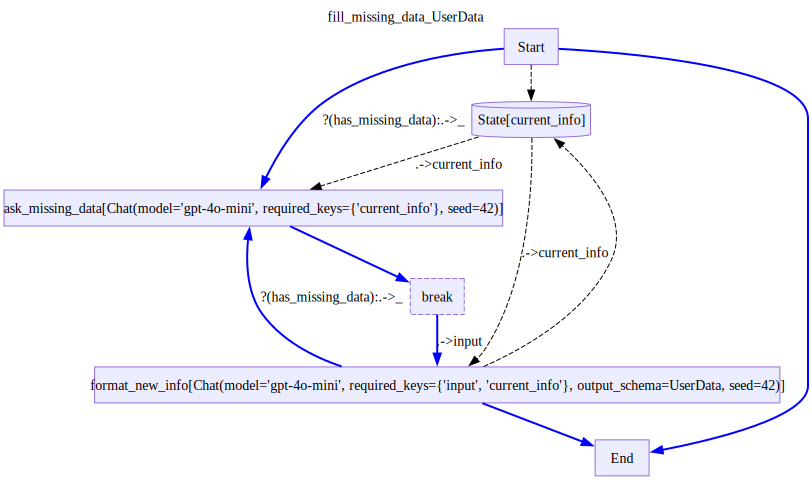

<stringdale.diagrams.DiagramSchema>

In [ ]:
FillMissingUserData = fill_missing_data_agent(UserData)
FillMissingUserData


In [ ]:
d = FillMissingUserData()
for trace in d.run({'content':UserData()}):
    trace.pprint()
    pass

d.output


Node Start:
{ 'input': {'content': UserData(name=None, age=None, email=None)},
  'output': {'content': UserData(name=None, age=None, email=None)}}
Node ask_missing_data:
{ 'input': { 'current_info': { 'content': UserData(name=None, age=None, email=None)}},
  'output': { 'content': 'Could you please provide your name, age, and email '
                         'address?',
              'meta': {'input_tokens': 150, 'output_tokens': 21},
              'role': 'assistant'}}


{'role': 'assistant',
 'content': 'Could you please provide your name, age, and email address?',
 'meta': {'input_tokens': 150, 'output_tokens': 21}}

In [ ]:
for trace in d.run('my name is jony'):
    pass

d.output


{'role': 'assistant',
 'content': "Hi Jony! I see that I have your name but I'm missing a few details. Could you please provide your age and email address?",
 'meta': {'input_tokens': 175, 'output_tokens': 36}}

In [ ]:
for trace in d.run('i am 25 years old'):
    pass

d.output

{'role': 'assistant',
 'content': 'Could you please provide your email address?',
 'meta': {'input_tokens': 176, 'output_tokens': 13}}

In [ ]:
for trace in d.run('sure, my email is jony@example.com'):
    pass

d.output

{'role': 'assistant',
 'content': UserData(name='jony', age=25, email='jony@example.com'),
 'meta': {'input_tokens': 367, 'output_tokens': 28}}